## Preprocessing of police district data - Trøndelag district

### Preprocessing steps for ALL police districts:
#### 1. Process road network
1. Import polygons of the relevant counties/municipalities
2. Subtract polygons of the municipalities that are not part of the police district
3. Import OSMnx road network from the resulting polygon
4. Impute edge speeds and travel times
5. Compute node centrality -> save as CSV
6. Save road network (with edge speeds and travel times) as GraphML

#### 2. Process population data
1. Subtract polygons of the municipalities that are not part of the police district
2. Import and clip population data to the resulting polygon
3. Save population data as GeoJSON

#### General notes:
- Save and Load all data in the default CRS: WGS84 (EPSG:4326)
- Transform data to correct UTM zone when needed for analysis. UTM zone 33N (EPSG:32633)

In [10]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-04-12T21:01:04.647259+02:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import igraph as ig
import pulp

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

shapely   : 2.0.3
numpy     : 1.26.4
pyproj    : 3.6.1
matplotlib: 3.8.3
igraph    : 0.11.4
geopandas : 0.14.3
pandas    : 2.2.1
pandana   : 0.7
osmnx     : 1.9.1
pulp      : 2.8.0
networkx  : 3.2.1



### 1. Process road network

Preprocessing steps for Øst police district as an example:
1. Import polygons of Akershus and Østfold counties
2. Subtract polygons of Asker, Bærum, Jevnaker and Lunner
3. Import OSMnx road network from the resulting polygon
4. Impute edge speeds and travel times
5. Compute node centrality -> save as CSV
6. Change graph CRS from WGS84 to UTM33N 
7. Save the network to a file -> save as GraphML

In [12]:
# import all police districts from file - geojson did not work for some reason
# police_districts_gdf = gpd.read_file("../data/police_districts/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_GeoJSON/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_GeoJSON.geojson")
# police_districts_gdf = gpd.read_file("../data/police_districts/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_GML/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_GML.gml", driver='GML')
districts_gdf = gpd.read_file("../data/police_districts/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_FGDB/Basisdata_0000_Norge_25833_PolitiSonerDistrikter_FGDB.gdb", driver='FileGDB', layer='PolitiDistrikt')
districts_gdf.head(2)

,objtype,lokalid,navnerom,versjonid,oppdateringsdato,datauttaksdato,geodataeier,geodataprodusent,politidistriktnavn,politidistriktnummer,SHAPE_Length,SHAPE_Area,geometry
0,Politidistrikt,87fae7b1-8dd5-4421-8aa7-a1fb0444a6d5,https://data.geonorge.no/sosi/administrativeen...,20221010,2022-09-07 00:00:00+00:00,2022-09-23 10:12:13+00:00,Politi- og lensmannsetaten,Kartverket,Sysselmesteren på Svalbard,62,194823.787,2982857059.273,"MULTIPOLYGON (((622945.587 8231320.844, 621945..."
1,Politidistrikt,a7e37bed-72ec-4751-8d5c-116f3cc29bcb,https://data.geonorge.no/sosi/administrativeen...,20221010,2022-09-07 00:00:00+00:00,2022-09-23 10:12:13+00:00,Politi- og lensmannsetaten,Kartverket,Sysselmesteren på Svalbard,62,1765995.016,132623763796.629,"MULTIPOLYGON (((642503.317 8974589.147, 643343..."


In [13]:
# Change CRS from UTM33N to WGS84
print("CRS of the districts_gdf:", districts_gdf.crs)
districts_gdf = districts_gdf.to_crs(epsg=4326)
print("CRS of the districts_gdf:", districts_gdf.crs)

CRS of the districts_gdf: EPSG:25833
CRS of the districts_gdf: EPSG:4326


In [14]:
def clean_data(police_districts_gdf):
    # Drop column: 'objtype'
    police_districts_gdf = police_districts_gdf.drop(columns=['objtype', 'navnerom', 'versjonid', 'oppdateringsdato', 'datauttaksdato', 'geodataeier', 'geodataprodusent'])
    police_districts_gdf = police_districts_gdf.rename(columns={'lokalid': 'lokalID', 'politidistriktnavn': 'districtName', 'politidistriktnummer': 'districtID'})
    
    # If districtName contains substring Svalbard in any upper/lower case combination, then delete row
    police_districts_gdf = police_districts_gdf[~police_districts_gdf['districtName'].str.contains('svalbard', case=False)]
    return police_districts_gdf

districts_clean = clean_data(districts_gdf.copy())
print("Shape of the cleaned dataset:", districts_clean.shape)
districts_clean.head(4)

Shape of the cleaned dataset: (12, 6)


,lokalID,districtName,districtID,SHAPE_Length,SHAPE_Area,geometry
5,e1762655-ad1e-4eaa-aa25-e7713bffea52,Oslo politidistrikt,201,240454.396,1233150525.719,"MULTIPOLYGON (((10.73101 59.87718, 10.71810 59..."
6,0864cb4d-a697-46ab-9a1f-ac4f802ae57f,Øst politidistrikt,202,675838.072,9817130626.535,"MULTIPOLYGON (((11.15351 59.07926, 11.12656 59..."
7,f6acc5e9-84a1-4c8f-8eb1-69d6da1ef1e8,Innlandet politidistrikt,203,1413687.019,52403856403.783,"MULTIPOLYGON (((10.77218 60.21377, 10.77231 60..."
8,d6c66ee5-09f7-46b8-a5c2-1a667c76820d,Sør-Øst politidistrikt,204,1028797.167,35223823522.815,"MULTIPOLYGON (((9.96977 58.72045, 9.78836 58.6..."


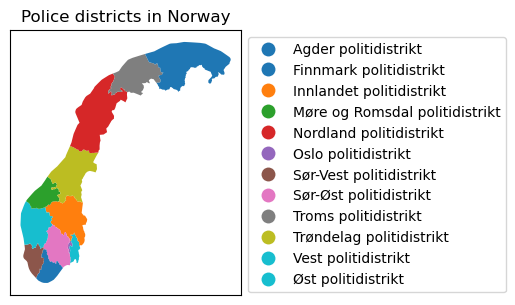

In [15]:
# plot the different districtNames
fig, ax = plt.subplots(figsize=(5, 5))
districts_clean.plot(ax=ax, column='districtName', legend=True, legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left', 'prop': {'size': 10}})
ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
plt.title('Police districts in Norway')
plt.tight_layout(); plt.show()

Now we have the polygon for the Øst police district. Note that this polygon does not have any coordinate system (CRS) info, we have to add this.   
For GeoDataFrames, we simply use the `to_crs` method, while for shapely polygons we use the `pyproj` library.

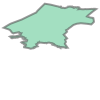

In [16]:
# Trondelag_gdf = districts_clean[districts_clean['districtName'] == 'Sør-Vest politidistrikt']
Trondelag_gdf = districts_clean[districts_clean['districtName'] == 'Trøndelag politidistrikt']
Trondelag_poly = Trondelag_gdf.iloc[0].geometry
Trondelag_poly

#### Step 2.5 - (OPTIONAL) Only add a subset of neighbouring district to original district

1) Create main graph (road network) of Original police district + relevant parts of neighbouring police districts.
2) Create subgraph of only Original police district. This will be used to only simulate Car and Event points in the Original police district.

In [8]:
# # Manually define polygon points for the relevant parts from the neighbouring district of interest 
# # Fetched from OpenStreetMap in WGS84 (EPSG:4326) format
# # OBS: Shapely construct polygons in counter-clockwise order, so the points should be defined in a sequential order
# coords = [
#     (4.300, 60.04),  # longitude and latitude of point 1
#     (4.0467, 58.8656),  # long/lat of point 2
#     (7.4647, 59.1171),
#     (7.217, 60.00),
# ]
# neighbouring_district_polygon = Polygon(coords) # Create Shapely polygon from point coordinates

# # optional preliminary steps to ensure a valid polygon
# neighbouring_district_polygon = neighbouring_district_polygon.buffer(0) # buffer by 0 to ensure valid polygon
# # neighbouring_district_polygon = neighbouring_district_polygon.simplify(0.0001, preserve_topology=False) # simplify polygon

# # Find the union of the two polygons
# # union_poly = Trondelag_poly.union(neighbouring_district_polygon)
# # TrondelagExt_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[union_poly])
# TrondelagExt_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[neighbouring_district_polygon])

# # intersection = Trondelag_gdf.iloc[0].geometry.intersection(neighbouring_district_polygon)
# # Trondelag_subset_gdf = gpd.GeoDataFrame(index=[0], crs='EPSG:4326', geometry=[intersection])

# # plot the resulting polygon, the intersection and the boundary points
# fig, ax = plt.subplots(figsize=(4,3))  # Adjust the size values as needed
# TrondelagExt_gdf.plot(ax=ax, color='lightgreen', alpha=0.7)
# Trondelag_gdf.plot(ax=ax, color='lightblue', alpha=0.7)
# x, y = zip(*coords)
# ax.scatter(x, y, color='red', s=10)
# x, y = neighbouring_district_polygon.exterior.xy
# ax.plot(x, y, color='blue', linewidth=1)
# for i, coord in enumerate(coords):
#     ax.text(coord[0], coord[1], f'{i+1}', fontsize=10, color='black')
# ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
# plt.title('Trondelag subset area')
# plt.tight_layout(); plt.show()

# TrondelagExt_poly = TrondelagExt_gdf.iloc[0].geometry
# # TrondelagExt_poly

In [17]:
%%time
# Step 3. Import OSMnx road network from the resulting polygon
# Trondelag_graph_edges = ox.graph_to_gdfs(Trondelag_graph, nodes=False, edges=True)
Trondelag_graph = ox.graph_from_polygon(Trondelag_poly, network_type="drive", simplify=True, retain_all=False, truncate_by_edge=False, custom_filter=None)
# TrondelagExt_graph = ox.graph_from_polygon(TrondelagExt_poly, network_type="drive", simplify=True, retain_all=False, truncate_by_edge=False, custom_filter=None)

# Backup - fetch from OSM boundaries of Rogaland (approximation of police district)
# Vestland_graph = ox.graph_from_place('Vestland, Norway', network_type="drive_service") # originally in WGS84 (EPSG:4326)

c:\ProgramData\miniconda3\envs\MCLP_env\Lib\site-packages\osmnx\_overpass.py:211: UserWarning: This area is 33 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


CPU times: total: 2min 15s
Wall time: 3min 23s


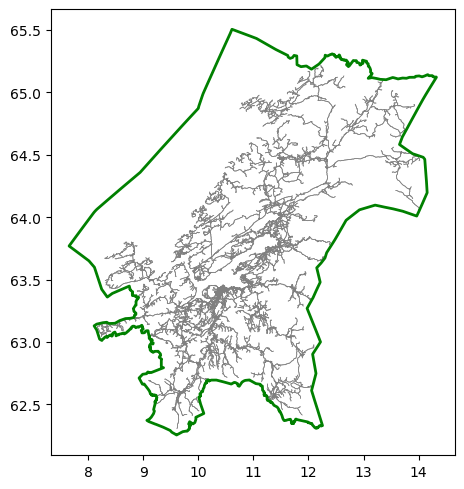

In [18]:
# plot boundary and road network
Trondelag_graph_edges = ox.graph_to_gdfs(Trondelag_graph, nodes=False, edges=True)

# Plot the road networks with the police district as background
fig, ax = plt.subplots(figsize=(5, 5))
Trondelag_graph_edges.plot(ax=ax, color='gray', linewidth=0.5)
Trondelag_gdf.boundary.plot(ax=ax, color='green', linewidth=2)
# plt.title('police district with road network')
plt.tight_layout(); plt.show()

Note that the north and south parts of the road network is not connected because one have to take a ferry between the two parts.

In [19]:
# Select a subset of columns - before imputing edge speeds
subset_columns = ['lanes', 'name', 'highway', 'oneway', 'reversed', 'length', 'maxspeed', 'ref', 'junction', 'bridge', 'width', 'tunnel']
subset_gdf = Trondelag_graph_edges[subset_columns]
# subset_gdf.head(4)

# impute speed on all edges missing data
Trondelag_graph = ox.speed.add_edge_speeds(Trondelag_graph)

# calculate travel time (seconds) for all edges
Trondelag_graph = ox.speed.add_edge_travel_times(Trondelag_graph)

# # converting graph to node and edge GeoPandas GeoDataFrames
Trondelag_gdf_nodes, Trondelag_gdf_edges = ox.graph_to_gdfs(Trondelag_graph)
print(f"type of Trondelag_gdf_nodes:{type(Trondelag_gdf_nodes)}")
Trondelag_gdf_edges.keys()

type of Trondelag_gdf_nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


Index(['osmid', 'highway', 'maxspeed', 'oneway', 'reversed', 'length',
       'geometry', 'speed_kph', 'travel_time', 'name', 'ref', 'bridge',
       'width', 'lanes', 'access', 'junction', 'tunnel', 'est_width'],
      dtype='object')

In [20]:
Trondelag_gdf_edges.head(2)

osmid                      highway  \
u       v          key                                                        
9855546 8332068274 0                  23735591                  residential   
        8332068278 0    [723741010, 373622063]  [unclassified, residential]   

                        maxspeed  oneway reversed  length  \
u       v          key                                      
9855546 8332068274 0          30   False    False  90.212   
        8332068278 0    [20, 40]   False    False 204.226   

                                                                 geometry  \
u       v          key                                                      
9855546 8332068274 0    LINESTRING (9.68604 62.59241, 9.68592 62.59248...   
        8332068278 0    LINESTRING (9.68604 62.59241, 9.68627 62.59250...   

                        speed_kph  travel_time             name  ref bridge  \
u       v          key                                                        
9855546 8332068274 0       30.000       10.800              NaN  NaN    NaN   
        8332068278 0       30.000       24.500  Ola Setroms veg  NaN    NaN   

                       width lanes access junction tunnel est_width  
u       v          key                                               
9855546 8332068274 0     NaN   NaN    NaN      NaN    NaN       NaN  
        8332068278 0     NaN   NaN    NaN      NaN    NaN       NaN

Here we verify the edges has new attributes: `speed_kph` and `travel_time`.

In [21]:
# # Export the graph to a file in GraphML format
ox.save_graphml(Trondelag_graph, "../data/Trondelag/TrondelagDriveImputed.graphml")

Next is computing the closeness centrality for each node in the network. This is a measure of how central a node is in the network. It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the network. The higher the value, the more central the node is.   
Current implementation uses the `networkx` library, which is quite slow and memory intensive for this operation. At least it is only computed once and saved to a CSV file.   
TODO: Implement a faster method for computing centrality.

In [22]:
%%time
# 5. Compute node centrality - using NetworkX (suitable for small graphs)
# Calculate closeness centrality
# Trondelag_centrality = nx.closeness_centrality(Trondelag_graph, distance='travel_time')
# Trondelag_gdf_nodes['closeness_centrality'] = Trondelag_gdf_nodes.index.map(Trondelag_centrality)

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
# 5. Compute node centrality - using igraph (suitable for large graphs)

# converting the networkx graph to an igraph graph
osmids = list(Trondelag_graph.nodes)
Trondelag_graph = nx.relabel.convert_node_labels_to_integers(Trondelag_graph)

# give each node its original osmid as attribute since we relabeled them
osmid_values = {k: v for k, v in zip(Trondelag_graph.nodes, osmids)}
nx.set_node_attributes(Trondelag_graph, osmid_values, "osmid")

In [24]:
%%time
# convert networkx graph to igraph
Trondelag_igraph= ig.Graph(directed=True)
Trondelag_igraph.add_vertices(Trondelag_graph.nodes)
Trondelag_igraph.add_edges(Trondelag_graph.edges())
Trondelag_igraph.vs["osmid"] = osmids
Trondelag_igraph.es["travel_time"] = list(nx.get_edge_attributes(Trondelag_graph, "travel_time").values())

CPU times: total: 62.5 ms
Wall time: 109 ms


In [25]:
assert len(Trondelag_graph.nodes()) == Trondelag_igraph.vcount()
assert len(Trondelag_graph.edges()) == Trondelag_igraph.ecount()

In [26]:
# check for any non-positive travel time values
non_positive_edges = [e for e in Trondelag_igraph.es if e["travel_time"] <= 0]
print(f"Number of non-positive travel time edges: {len(non_positive_edges)}")

# show the non-positive travel time edges
non_positive_edges[:]

# inspect the non-positive travel time edges, if small we can set them to a small positive value
for e in non_positive_edges:
    print(e.tuple, e["travel_time"])

# Set the non-positive travel time edges to a small positive value
for e in non_positive_edges:
    e["travel_time"] = 1

# Re-check for any non-positive travel time values
non_positive_edges = [e for e in Trondelag_igraph.es if e["travel_time"] <= 0]
print(f"Number of non-positive travel time edges (2nd time): {len(non_positive_edges)}")

# this returned 6 non-positive travel time edges. This can happen when the travel time is not imputed for some edges.
# We can either remove these edges or impute the travel time for them. Here we added a small positive value to the travel time.

Number of non-positive travel time edges: 1
(20309, 20729) 0.0
Number of non-positive travel time edges (2nd time): 0


In [27]:
%%time
# closeness centrality with igraph - incoming and outgoing paths
closeness1 = Trondelag_igraph.closeness(vertices=None, mode="all", cutoff=None, weights="travel_time", normalized=True)
max_closeness1 = np.argmax(closeness1)

CPU times: total: 59.3 s
Wall time: 1min 12s


In [28]:
%%time
# betweenness centrality with igraph
betweenness1 = Trondelag_igraph.betweenness(vertices=None, directed=True, cutoff=None, weights="travel_time")
max_betweenness1 = np.argmax(betweenness1)

CPU times: total: 1min 18s
Wall time: 1min 38s


In [29]:
# inspect the maximum centrality values
print(f"Max closeness centrality (1st method): {max_closeness1}, {closeness1[max_closeness1]}")
print(f"Max betweenness centrality (1st method): {max_betweenness1}, {betweenness1[max_betweenness1]}")

Max closeness centrality (1st method): 12469, 0.00021286019187185504
Max betweenness centrality (1st method): 10132, 310831362.0


In [30]:
# adding the centrality values to the node GeoDataFrame
Trondelag_gdf_nodes["closeness_centrality"] = closeness1 # all nodes
Trondelag_gdf_nodes["betweenness_centrality"] = betweenness1 # all nodes

In [31]:
Trondelag_gdf_nodes.head(2)

,y,x,street_count,highway,ref,geometry,closeness_centrality,betweenness_centrality
osmid,,,,,,,,
9855546,62.592,9.686,4,NaN,NaN,POINT (9.68604 62.59241),0.000,5163089.000
359891580,62.593,9.693,1,NaN,NaN,POINT (9.69341 62.59339),0.000,0.000


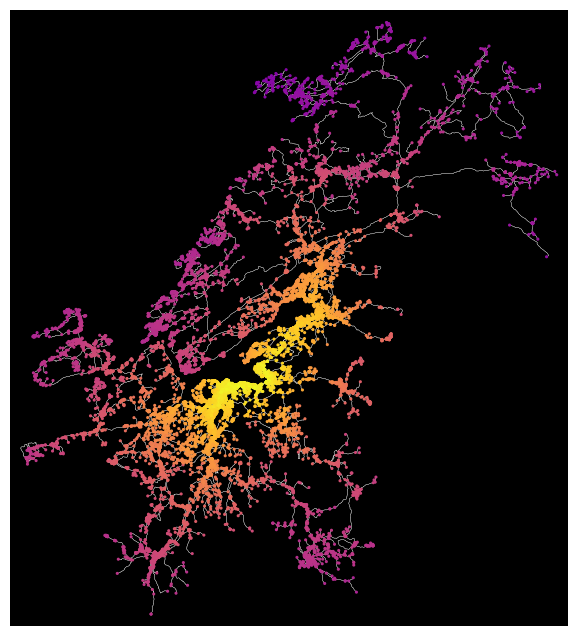

In [32]:
# Plot the road network with the closeness centrality values as node colors - using OSMnx
# node_color
nc = Trondelag_gdf_nodes["closeness_centrality"]
nc = nc / nc.max()
nc = plt.cm.plasma(nc)

# plot the road network with the closeness centrality values as node colors
fig, ax = ox.plot_graph(Trondelag_graph, node_size=5, node_color=nc, edge_color="w", edge_linewidth=0.2, bgcolor="k", show=False, close=False)
plt.show()

# # Plot the road network with the police district as background
# fig, ax = ox.plot_graph(Trondelag_graph, node_size=0, edge_linewidth=0.5, bgcolor='black', show=False, close=False)
# Trondelag_graph.boundary.plot(ax=ax, color='green', linewidth=2)
# plt.title('Innlandet police district with road network')
# plt.tight_layout(); plt.show()

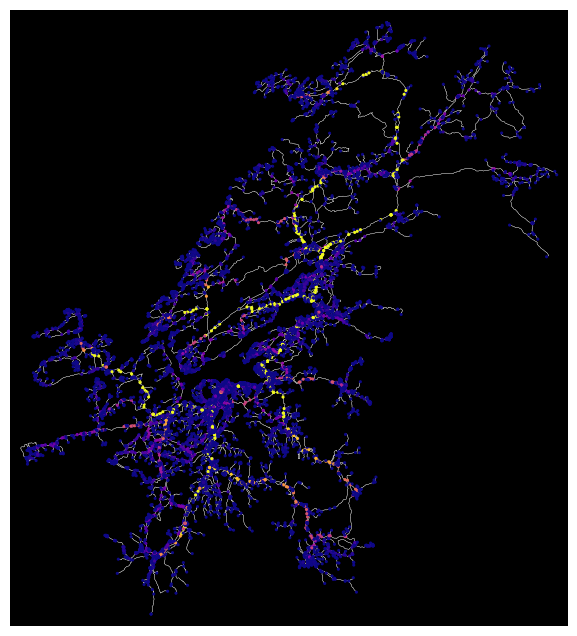

In [33]:
# Plot the road network with the betweenness centrality values as node colors - using OSMnx
# node_color
scale_factor = 10
nc = Trondelag_gdf_nodes["betweenness_centrality"]
nc = scale_factor * nc / nc.max()
nc = plt.cm.plasma(nc)

# plot the road network with the betweenness centrality values as node colors
fig, ax = ox.plot_graph(Trondelag_graph, node_size=5, node_color=nc, edge_color="w", edge_linewidth=0.2, bgcolor="k", show=False, close=False)
plt.show()

In [34]:
# Save centrality to CSV file with 'closeness_centrality' and 'betweenness' columns and 'osmid' as index

# Prepare the node GeoDataFrame for saving to CSV file with 'closeness_centrality' columns and 'osmid' as index
Trondelag_gdf_nodes_centrality = Trondelag_gdf_nodes[["closeness_centrality", "betweenness_centrality"]]
Trondelag_gdf_nodes_centrality.to_csv("../data/Trondelag/TrondelagNodeCentrality.csv", index=True) # recently changed this to True

# Load centrality from CSV file
Trondelag_gdf_nodes_imported = pd.read_csv("../data/Trondelag/TrondelagNodeCentrality.csv", index_col=0)
Trondelag_gdf_nodes_imported.head(2)

# print the single highest closeness centrality value
max_closeness = Trondelag_gdf_nodes_imported["closeness_centrality"].max()
print(f"Max closeness centrality: {max_closeness}")

Max closeness centrality: 0.0002128601918718


In [35]:
Trondelag_gdf_nodes_imported.head(2)

,closeness_centrality,betweenness_centrality
osmid,,
9855546,0.000,5163089.000
359891580,0.000,0.000


The CRS of the road network have remained unchanged as WGS4 (EPSG:4326).   
Conversion to UTM33N (EPSG:32633) is done after importing the network and before any analysis.

### 2. Process population data
1. Import counties/municipalitiy population data for the police district.
2. Import and clip population data to the resulting polygon.
3. Save population data as GeoJSON.

Inland police district consists of the counties Hedmark and Oppland.

In [36]:
# Step 1. Import counties/municipalitiy population data for the police district
# Load Trondelag population data
# Trondelag_population_path = "../data/Trondelag/ssb_data/v_ru250m_2023_rutenett.geojson"
vestland_population_path = "../data/Trondelag/ssb_data/v_ru250m_2023_rutenett.geojson"
# vestland_population_path = "../data/Trondelag/ssb_data/vestland/v_ru250m_2023_rutenett.geojson"
# rogaland_population_path = "../data/Trondelag/ssb_data/rogaland/v_ru250m_2023_rutenett.geojson"
# jevnaker_population_path = "../data/Trondelag/ssb_data/jevnaker/v_ru250m_2023_rutenett.geojson"

# Trondelag_population = gpd.read_file(Trondelag_population_path)
# agder_population = gpd.read_file(agder_population_path)
vestland_population = gpd.read_file(vestland_population_path)
# rogaland_population = gpd.read_file(rogaland_population_path)
# jevnaker_population = gpd.read_file(jevnaker_population_path)

# rename columns
# for gdf in [agder_population, vestland_population, rogaland_population]:
#     gdf.columns = ['id', 'population', 'geometry']
vestland_population.columns = ['id', 'population', 'geometry'] # rename column names

In [37]:
%%time
# Step 2. Import and clip population data to the resulting polygon.
# Already have 'Trondelag_poly' from previous steps to clip the population data

# combine the population data
# population_gdf = pd.concat([agder_population, vestland_population, rogaland_population], axis=0)
population_gdf = vestland_population

# clip the population data to the resulting polygon
clipped_population = gpd.clip(population_gdf, Trondelag_poly)
# clipped_population = Trondelag_population

CPU times: total: 19 s
Wall time: 21.4 s


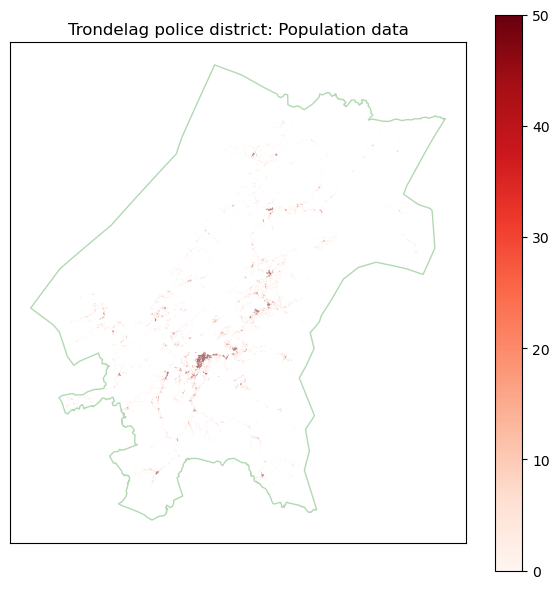

In [38]:
# plot the clipped population data, with the combined polygon as outline and the population colored by population size
fig, ax = plt.subplots(figsize=(6,6))  # Adjust the size values as needed
Trondelag_gdf.boundary.plot(ax=ax, color='green', linewidth=1, alpha=0.3, zorder=-1)

# set custom range for the color map
vmin, vmax = 0, 50
clipped_population.plot(ax=ax, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
# Trondelag_population.plot(ax=ax, column='population', cmap='jet', legend=True, alpha=0.7)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Trondelag police district: Population data')
plt.tight_layout(); plt.show()

In [39]:
# Step 3. Save population data as GeoJSON.

# Save the clipped population data to a file
clipped_population.to_file("../data/Trondelag/TrondelagPopulation.geojson", driver="GeoJSON")

# load the population data from the file
Trondelag_population_imported = gpd.read_file("../data/Trondelag/TrondelagPopulation.geojson")
Trondelag_population_imported.head(2)

,id,population,geometry
0,22205006920000,1,"POLYGON ((9.60494 62.30660, 9.60453 62.30883, ..."
1,22217506934000,2,"POLYGON ((9.60645 62.43264, 9.60605 62.43487, ..."


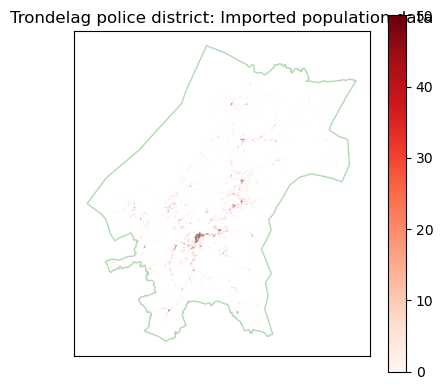

In [40]:
# plot the imported population data for verification
fig, ax = plt.subplots(figsize=(4,4))  # Adjust the size values as needed
Trondelag_gdf.boundary.plot(ax=ax, color='green', linewidth=1, alpha=0.3, zorder=-1)
Trondelag_population_imported.plot(ax=ax, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Trondelag police district: Imported population data')
plt.tight_layout(); plt.show()

In [41]:
# Also save the combined polygon to a file, but cannot save polygon directly
# Convert the polygon to a GeoDataFrame with a single row
Trondelag_poly_gdf = gpd.GeoDataFrame(geometry=[Trondelag_poly])
Trondelag_poly_gdf.to_file("../data/Trondelag/TrondelagCombinedPolygon.geojson", driver="GeoJSON")

# Load the combined polygon from the file
Trondelag_poly_imported = gpd.read_file("../data/Trondelag/TrondelagCombinedPolygon.geojson")
Trondelag_poly_imported.head(2)

,geometry
0,"MULTIPOLYGON (((10.57806 65.47017, 10.57911 65..."


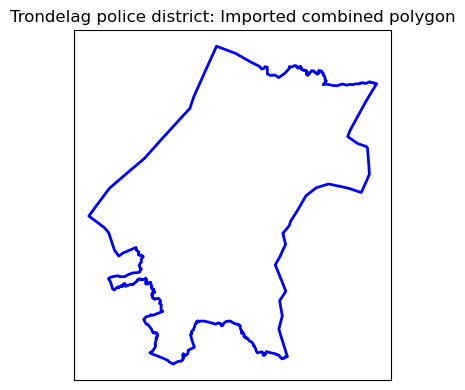

In [42]:
# plot the imported combined polygon for verification
fig, ax = plt.subplots(figsize=(4,4))  # Adjust the size values as needed
Trondelag_gdf.boundary.plot(ax=ax, color='green', linewidth=1, alpha=0.3, zorder=-1)
Trondelag_poly_imported.boundary.plot(ax=ax, color='blue', linewidth=2)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.title('Trondelag police district: Imported combined polygon')
plt.tight_layout(); plt.show()